# Vehicle Valuation

A used car dealership service is developing an application to attract new customers. In this application, users can quickly find out the market value of their car. We have historical data at our disposal: technical specifications, trim levels, and car prices. The service need an ML model to determine the value.

The client prioritizes:

- Prediction quality
- Prediction speed
- Training time

In [2]:
! pip install phik -q
! pip install lightgbm -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
    OneHotEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, make_scorer
# import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt
# import phik

import time

# from sklearn.exceptions import FitFailedWarning
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Data preparation

In [4]:
autos_df = pd.read_csv('../datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [5]:
def df_description(df):
    print('shape: ', df.shape)
    display(df.head())
    df.info()
    display(pd.DataFrame(round(df.isna().mean()*100,2)).style.background_gradient('coolwarm'))

In [6]:
df_description(autos_df)

shape:  (354369, 16)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.580000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.560000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.280000


There are a lot of missing values in the data. These will be filled with the "Unknown" category later on.

In total, there are 354,369 car records. During data preparation and cleaning, you'll need to ensure that at least 90% (318,933 records) remain.

In [7]:
def cat_plots(df, columns):
    for col in columns:
        counts = df[col].value_counts()
        labels = counts.index.tolist()
        sizes = counts.values.tolist()

        plt.figure(figsize=(3, 3))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')

        plt.title(f'Number of cars by "{col}"')
        plt.show()
                
                
def num_plots(df, columns):
    for col in columns:
        display(df[col].describe())
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df[col], showfliers=False)
        plt.title(f'Distribution of "{col}"')

        plt.subplot(1, 2, 2)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of "{col}"')

        plt.tight_layout()
        plt.show()
        

def discrete_plots(df, columns):
    for col in columns:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 2)
        sns.countplot(x=col, data=df)
        plt.title(f'Distribution of "{col}"')
        plt.show()

In [8]:
num_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
discrete_columns = ['RegistrationMonth', 'NumberOfPictures']

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

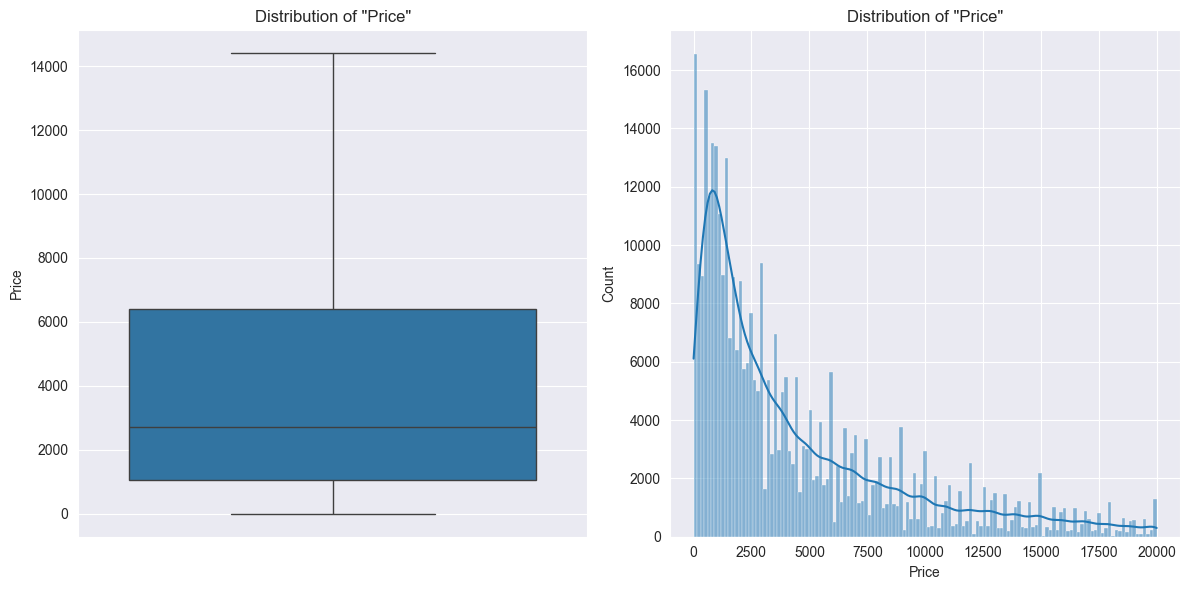

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

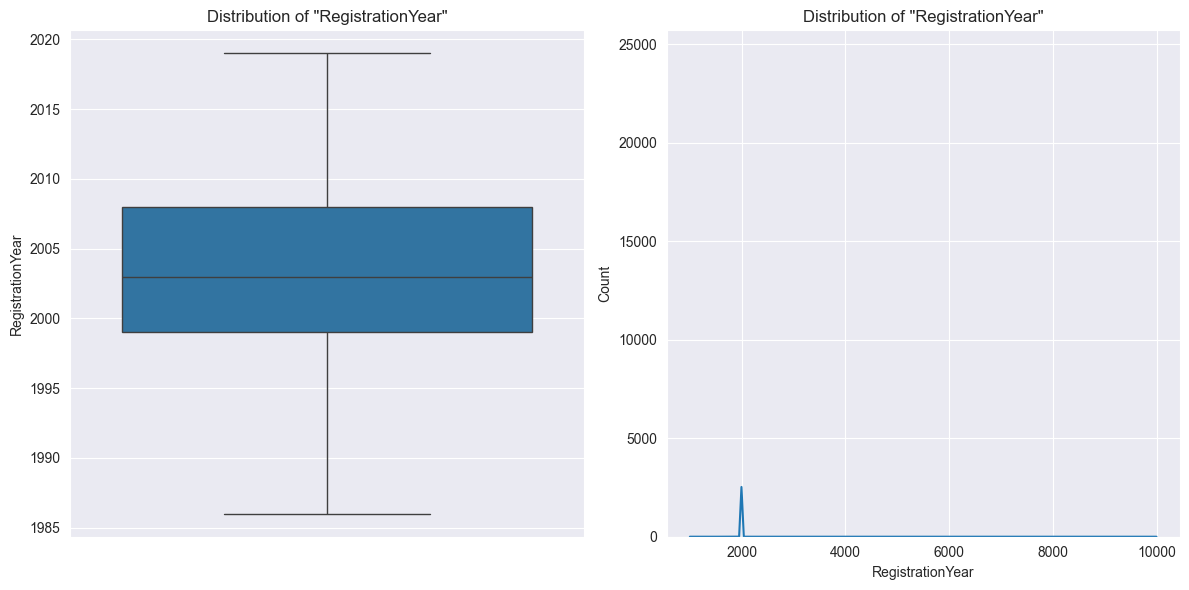

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

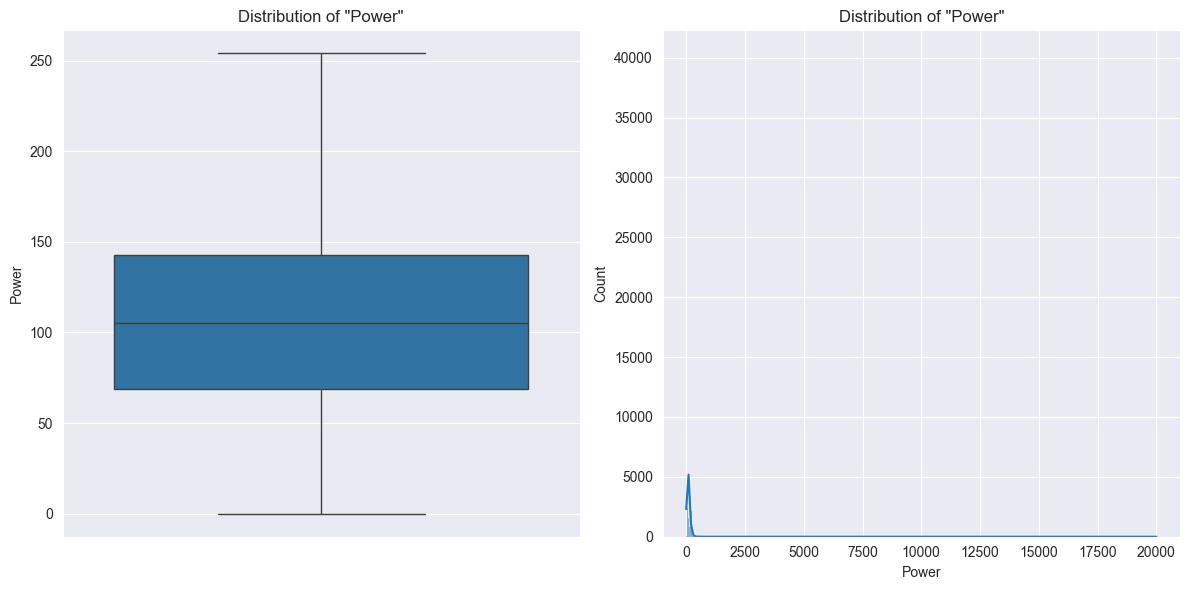

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

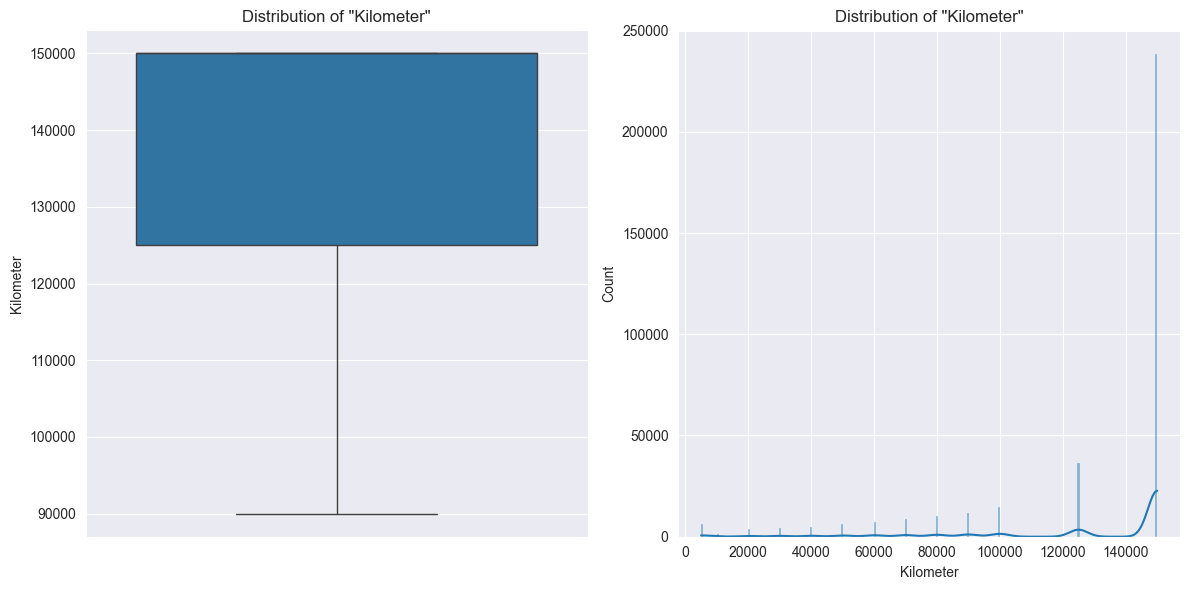

In [9]:
num_plots(autos_df, num_columns)

The price ranges from 0 to 20,000, and this is our target variable. We'll also remove values where the price is below 500. Even though this will result in a significant loss of data, getting rid of these anomalies will help the model make more accurate predictions.
We'll also remove any values where the price is below 500. While removing these values means losing a significant portion of our data, getting rid of such anomalies will help the model make more accurate predictions.

There are clear anomalies in the year and power values. After we create all the plots, we'll decide which values to remove.

In [10]:
autos_df.query('Price == 0')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32


In [11]:
# For car models and brands, it's not very informative to create diagrams, so we'll just find out how many different categories there are.
print(f"Model: {autos_df['Model'].nunique()}\nBrand: {autos_df['Brand'].nunique()}\nFuel Type: {autos_df['FuelType'].nunique()}")

Model: 250
Brand: 40
Fuel Type: 7


In [12]:
autos_df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [13]:
autos_df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

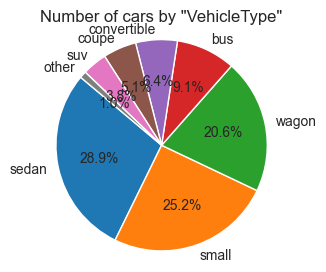

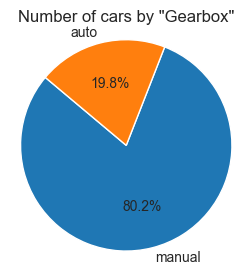

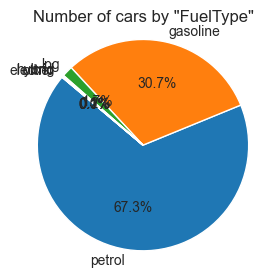

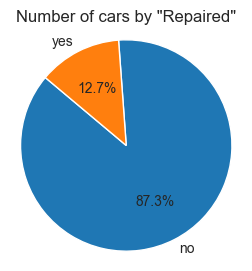

In [14]:
cat_plots(autos_df, ['VehicleType', 'Gearbox', 'FuelType', 'Repaired'])

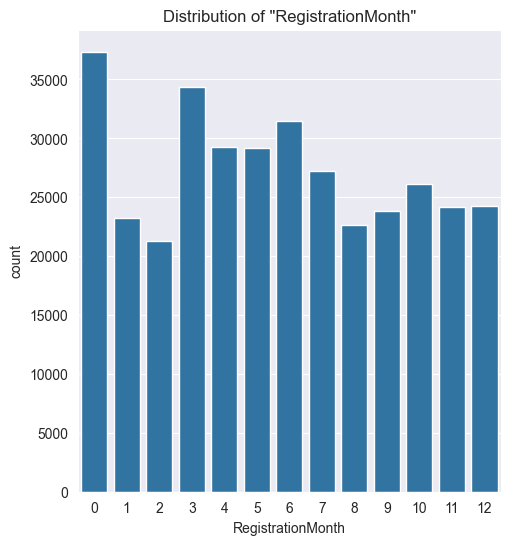

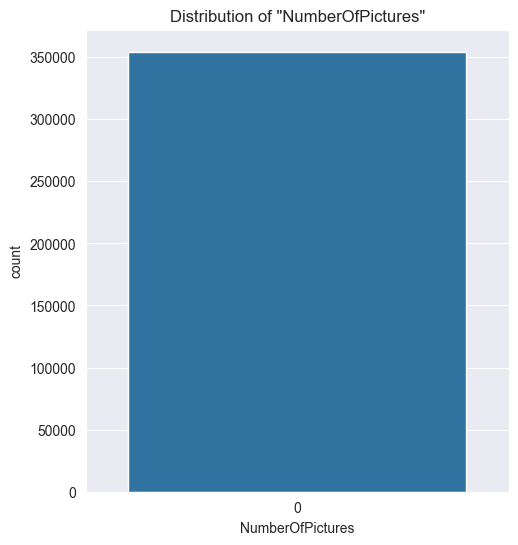

In [15]:
discrete_plots(autos_df, discrete_columns)

The distribution by month looks logical, but there are many zero values. These will need to be replaced with "unknown" later.

In [16]:
autos_df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [17]:
autos_df.query('RegistrationYear > 2024 or RegistrationYear < 1924 or Power > 2000 ')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16,0,44628,2016-03-20 16:44:37
6629,2016-04-02 13:47:16,0,small,1910,NaN,0,NaN,5000,1,other,sonstige_autos,NaN,2016-04-02,0,93105,2016-04-04 11:16:30
6977,2016-03-24 08:37:22,135,NaN,1910,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-24,0,19374,2016-04-06 20:46:08
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02,0,65830,2016-04-06 11:46:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348237,2016-04-04 12:38:11,3000,coupe,2007,manual,2007,corsa,150000,3,gasoline,opel,yes,2016-04-04,0,72218,2016-04-04 12:38:11
348668,2016-03-05 17:53:09,1000,wagon,1996,manual,2598,a6,150000,7,NaN,audi,NaN,2016-03-05,0,7646,2016-03-07 16:17:01
348830,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21,0,41472,2016-04-05 14:18:01
351682,2016-03-12 00:57:39,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03-11,0,16515,2016-04-05 19:47:27


There are a total of 395 values where the registration year is later than 2024 or earlier than 1924, or the power exceeds 2000 hp. The thresholds for year and power were chosen based on logical reasoning, as no additional information on standard values was provided. We'll remove these values, as 395 falls within the acceptable range for the number of values to be deleted.

In [18]:
autos_df = autos_df.query('RegistrationYear <= 2024 and RegistrationYear >= 1924 and Power <= 2000 and Price > 0')
autos_df.shape

(343288, 16)

In [19]:
autos_df.query('DateCrawled < 2016')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Since the download dates for the car listings are only available for 2016, it's logical to assume we should limit the car registration year to 2016 as well. This will ensure our data is consistent with the timeframe of the listings.

In [20]:
autos_df = autos_df.query('RegistrationYear <= 2016')
autos_df.shape

(329604, 16)

### Removing Features

NumberOfPictures is the same for all entries, so it doesn't provide any useful information for the model. We're also removing features like zip codes and dates, as they aren't characteristics of the car itself.

In [21]:
new_df = autos_df.drop(['DateCrawled', 'PostalCode', 'DateCreated', 'NumberOfPictures', 'LastSeen'], axis=1)
new_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [22]:
new_df.shape

(329604, 11)

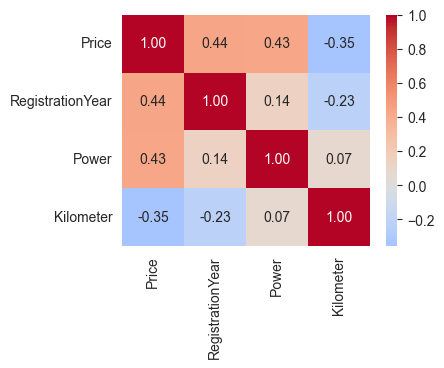

In [23]:
plt.figure(figsize=(4, 3))
sns.heatmap(new_df[num_columns].corr(method='pearson'), fmt='.2f', cmap='coolwarm', center=0, annot=True)
plt.show()

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(new_df.phik_matrix(\
                               interval_cols=['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']), \
            fmt='.2f', cmap='coolwarm', center=0, annot=True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'phik_matrix'

<Figure size 800x600 with 0 Axes>

The Model feature has a high correlation with the Brand and VehicleType features.

In [25]:
new_df = new_df.drop(['Model'], axis=1)

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(new_df.phik_matrix(\
                               interval_cols=['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']), \
            fmt='.2f', cmap='coolwarm', center=0, annot=True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'phik_matrix'

<Figure size 800x600 with 0 Axes>

In [26]:
new_df.duplicated().sum()

np.int64(25505)

After removing features, we ended up with a significant number of duplicate entries. We need to remove these duplicates to ensure proper model training. Even without them, we still have a sufficient amount of data.

In [27]:
new_df.drop_duplicates(inplace=True)
new_df.shape

(304099, 11)

### Splitting the Data

In [28]:
X = new_df.drop(columns=['Price'])
y = new_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Model Training

Next, the features were divided into numerical and categorical.

The Year feature is left as numerical because it has a fairly wide range of values, and one-hot encoding (OHE) would create too many unnecessary features.

In [29]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', \
                'Brand', 'Repaired']

num_columns = ['RegistrationYear', 'Power', 'Kilometer']

In [30]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe_nan', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')
        ),
        (
            'simpleImputer_before_ohe_zero', 
            SimpleImputer(missing_values=0, strategy='constant', fill_value='Unknown')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [31]:
month_pipe = Pipeline(
    [
        (
            'to_string', 
            FunctionTransformer(lambda x: x.astype(str), validate=False)
        ),
        (
            'simpleImputer_before_ohe_nan', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')
        ),
        (
            'simpleImputer_before_ohe_zero', 
            SimpleImputer(missing_values='0', strategy='constant', fill_value='Unknown')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [38]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('month', month_pipe, ['RegistrationMonth']),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [39]:
final_p = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [40]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
rmse_scorer = make_scorer(rmse, greater_is_better=False)


In [41]:
parameters = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [20, 40],
        'models__max_depth': [-1, 4],
        'preprocessor__num': [StandardScaler(), 'passthrough'],        
    }
]

In [42]:
search = GridSearchCV(
    final_p, 
    parameters,
    n_jobs=-1,
    cv=5, 
    scoring=rmse_scorer,
    error_score='raise'
)

In [43]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe_nan',
                                                                                          SimpleImputer(fill_value='Unknown',
                                                                                                        strategy='constant')),
                                                                                         ('simpleImputer_before_ohe_zero',
                                                                                          SimpleImputer(fill_value='Unknown',
                                                                                                        missing_value

## Model Analysis

In [44]:
results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,param_models__max_depth,param_models__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,4.109613,0.549124,0.305890,0.004594,"LGBMRegressor(n_estimators=30, random_state=42)",StandardScaler(),-1,30,"{'models': LGBMRegressor(n_estimators=30, rand...",-1950.297988,-1926.792169,-1939.983279,-1962.815901,-1970.511983,-1950.080264,15.645980,1
5,3.557324,0.051664,0.339699,0.043242,"LGBMRegressor(n_estimators=30, random_state=42)",passthrough,-1,30,"{'models': LGBMRegressor(n_estimators=30, rand...",-1955.781169,-1927.569205,-1937.615529,-1968.375734,-1966.114605,-1951.091248,16.008320,2
8,3.271940,0.373961,0.301713,0.004703,"LGBMRegressor(n_estimators=30, random_state=42)",StandardScaler(),4,30,"{'models': LGBMRegressor(n_estimators=30, rand...",-2129.057045,-2099.278578,-2114.847069,-2132.337800,-2137.983416,-2122.700782,13.979367,3
9,3.133941,0.077061,0.303329,0.059235,"LGBMRegressor(n_estimators=30, random_state=42)",passthrough,4,30,"{'models': LGBMRegressor(n_estimators=30, rand...",-2129.066719,-2112.257493,-2114.756151,-2143.056365,-2136.658007,-2127.158947,12.020668,4
3,2.702023,0.082086,0.283847,0.027673,"LGBMRegressor(n_estimators=30, random_state=42)",passthrough,-1,10,"{'models': LGBMRegressor(n_estimators=30, rand...",-2667.577322,-2641.527396,-2662.314180,-2671.093052,-2678.197817,-2664.141953,12.429367,5
2,2.821334,0.255476,0.267417,0.036155,"LGBMRegressor(n_estimators=30, random_state=42)",StandardScaler(),-1,10,"{'models': LGBMRegressor(n_estimators=30, rand...",-2667.691731,-2643.169684,-2663.957863,-2670.101223,-2678.763886,-2664.736878,11.832287,6
7,2.612390,0.199387,0.267228,0.036872,"LGBMRegressor(n_estimators=30, random_state=42)",passthrough,4,10,"{'models': LGBMRegressor(n_estimators=30, rand...",-2805.902836,-2778.084294,-2793.667858,-2800.608186,-2809.023843,-2797.457403,10.997394,7
6,2.508476,0.076299,0.268235,0.034908,"LGBMRegressor(n_estimators=30, random_state=42)",StandardScaler(),4,10,"{'models': LGBMRegressor(n_estimators=30, rand...",-2805.829591,-2778.007376,-2793.600339,-2800.528497,-2812.603111,-2798.113783,11.831686,8
1,4.443272,0.166832,0.361911,0.044645,LinearRegression(),passthrough,NaN,NaN,"{'models': LinearRegression(), 'preprocessor__...",-2969.628653,-2955.639824,-2927.784633,-2926.818945,-2962.167414,-2948.407894,17.795209,9
0,4.438842,0.204770,0.349563,0.037471,LinearRegression(),StandardScaler(),NaN,NaN,"{'models': LinearRegression(), 'preprocessor__...",-2969.628653,-2955.639824,-2927.784633,-2926.818945,-2962.167414,-2948.407894,17.795209,10


The RMSE values for the first and second models don't differ significantly, but the second model has better training and prediction times. Therefore, we'll proceed with the second model.

<div class='alert alert-warning'>⚠️(2)Тут у второй время обучения лучше, а предказания чуть хуже
</div>

In [45]:
second_best_model_params = results.iloc[1]['params']

In [46]:
second_best_model_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', second_best_model_params['models'])
    ]
)

In [47]:
second_best_model_pipeline.set_params(preprocessor__num=second_best_model_params['preprocessor__num'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe_nan',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('simpleImputer_before_ohe_zero',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 missing_values=0,
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                

In [51]:
start_time = time.time()
second_best_model_pipeline.fit(X_train, y_train)
fit_time = time.time() - start_time

In [52]:
start_time = time.time()
y_pred = second_best_model_pipeline.predict(X_test)
predict_time = time.time() - start_time

In [53]:
print(f'RMSE test: {(-1)*rmse_scorer(second_best_model_pipeline, X_test, y_test)} \
      \nFit time: {fit_time} \
      \nPredict time: {predict_time}')

RMSE test: 1947.702256250951       
Fit time: 4.415492534637451       
Predict time: 0.45758652687072754


In [54]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)
print('RMSE test, DummyRegressor:', (-1)*rmse_scorer(dummy_regressor, X_test, y_test))

RMSE test, DummyRegressor: 4533.739137717185


The best model based on the metric value and training time is LGBMRegressor(n_estimators=30, random_state=42) with StandardScaler() for numerical preprocessing.

The metric value on the test data is 1947.7.

This found model significantly outperforms the DummyRegressor results.